In [1]:
from collections import defaultdict
import glob
import os

import numpy as np
import matplotlib.pyplot as plt

from tools import get_deformation_elems, get_deformation_2files
%matplotlib notebook

In [2]:
def compute_a_p(x, y, t):
    a = 0.5 * np.abs((x[t[:,1]]-x[t[:,0]])*(y[t[:,2]]-y[t[:,0]]) - (x[t[:,2]]-x[t[:,0]])*(y[t[:,1]]-y[t[:,0]]))
    p = np.hypot(x[t[:,1]]-x[t[:,0]], y[t[:,1]]-y[t[:,0]]) + np.hypot(x[t[:,2]]-x[t[:,1]], y[t[:,2]]-y[t[:,1]]) + np.hypot(x[t[:,0]]-x[t[:,2]], y[t[:,0]]-y[t[:,2]])
    return a, p


In [3]:
field_files = sorted(glob.glob('/data2/antonk/music/coast10km_bbm_P0_exp11/field_2*npz'))
print(len(field_files), field_files[0], field_files[-1])

2161 /data2/antonk/music/coast10km_bbm_P0_exp11/field_20070101T000000Z.npz /data2/antonk/music/coast10km_bbm_P0_exp11/field_20070101T030000Z.npz


In [4]:
ts = defaultdict(list)
for field_file in field_files[0:350]:
    n = dict(np.load(field_file))
    x = n['x']
    y = n['y']
    t = n['t']
    s0 = n['Sigma_0']
    s1 = n['Sigma_1']
    d = n['Damage']
    u = n['M_VT'][0]
    v = n['M_VT'][1]    
    
    a, p = compute_a_p(x, y, t)
    e1, e2, e3 = get_deformation_elems(x[t].T, y[t].T, u[t].T, v[t].T, a)
    ts['e1'].append(e1)
    ts['e2'].append(e2)
    ts['s0'].append(s0)
    ts['s1'].append(s1)
    ts['d'].append(d)
    

for j in ts:
    ts[j] = np.array(ts[j])        

In [5]:
sigma_n = ts['s0']
sigma_s = ts['s1']


In [6]:
delta_x = 6500
c_lab = 2e6
c_fix = c_lab * (0.1 / delta_x) ** 0.5
print(c_fix)
cfix = 7809.73
tan_phi = 0.7

7844.645405527361


<IPython.core.display.Javascript object>


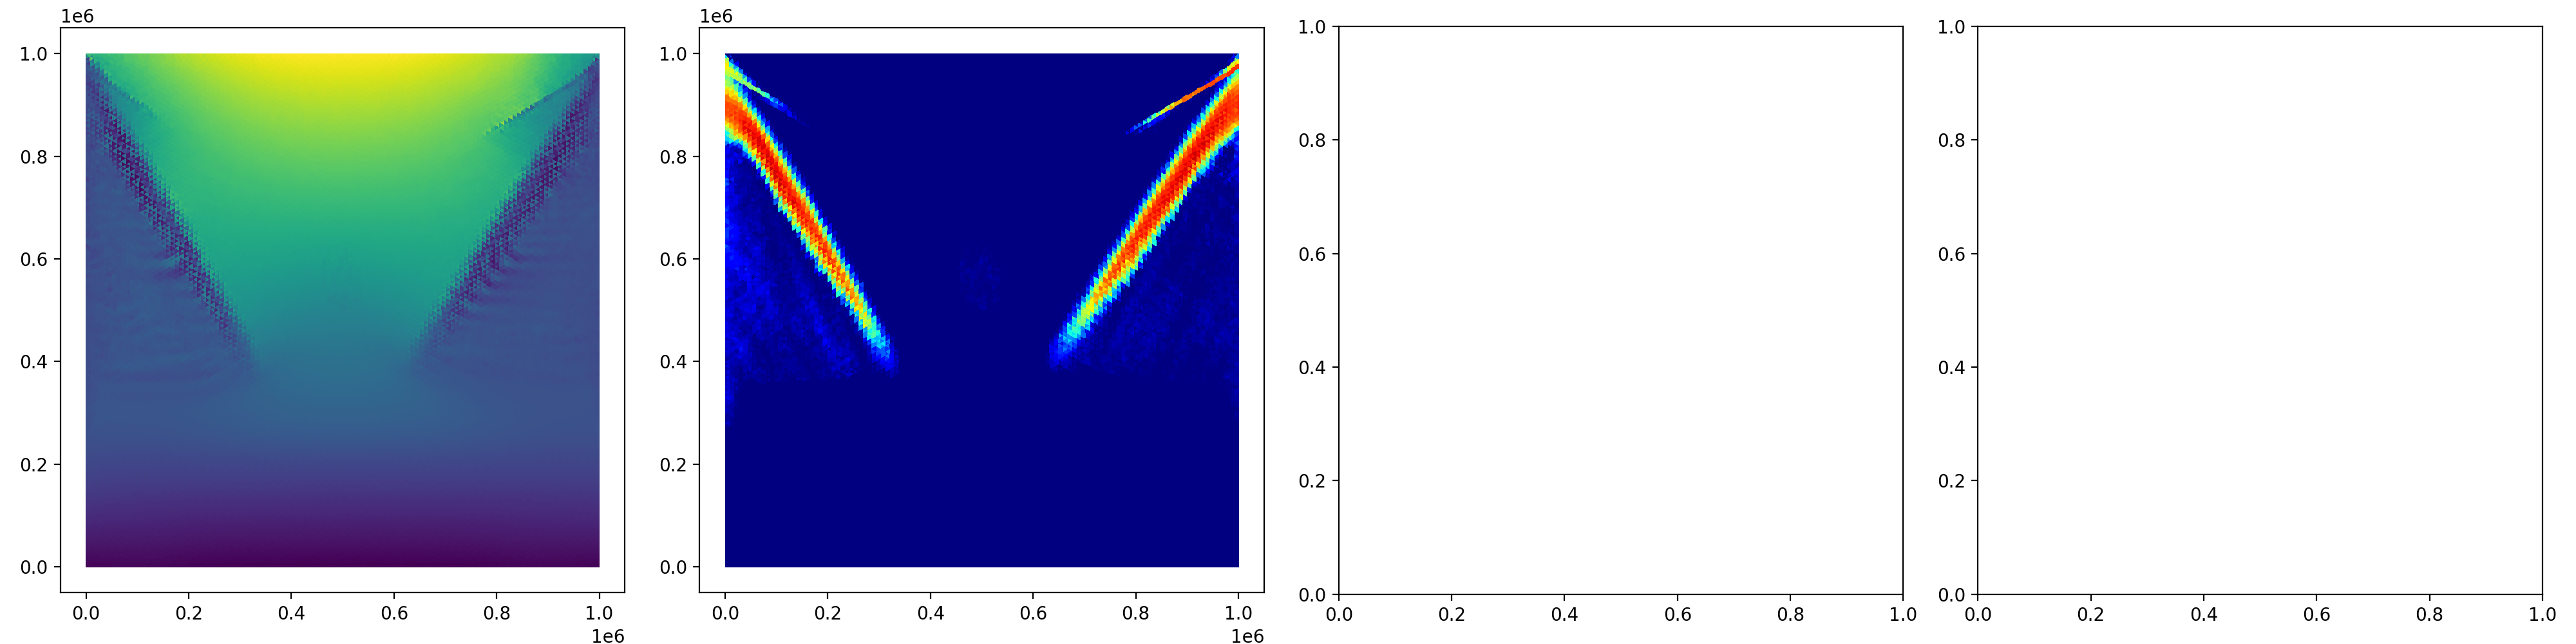

In [7]:
max_n = c_fix / tan_phi
mc_n = np.arange(-30e3, max_n)
mc_t = c_fix - tan_phi * mc_n


elx = x[t].mean(axis=1)
ely = y[t].mean(axis=1)

fig, axs = plt.subplots(1,4, figsize=(20, 5))
trp = axs[0].tripcolor(x, y, sigma_n[-1], triangles=t, cmap='viridis_r')
axs[0].set_aspect('equal')
axs[1].tripcolor(x, y, ts['d'][-1], triangles=t, cmap='jet', vmin=0, vmax=1)
axs[1].set_aspect('equal')

steps = np.arange(sigma_n.shape[0])

ax1_line = None
ax1_scat = None
el_id = None

def onclick(event):
    global el_id
    if event.inaxes not in axs[:2]:
        return
    el_id = np.argmin(np.hypot(elx - event.xdata, ely - event.ydata))

    d_crit = c_fix / (sigma_s[:, el_id] + tan_phi*sigma_n[:, el_id])
    #d_crit = ts['dcrt'][:, el_id]

    for l in axs[0].lines:
        axs[0].lines.remove(l)
    axs[0].plot(event.xdata, event.ydata, 'xr', zorder=10)

    for l in axs[1].lines:
        axs[1].lines.remove(l)
    axs[1].plot(event.xdata, event.ydata, 'xr', zorder=10)

    i = 2
    for l in axs[i].lines:
        axs[i].lines.remove(l)
    for l in axs[i].collections:
        axs[i].collections.remove(l)
    axs[i].plot(sigma_n[:, el_id], sigma_s[:, el_id], 'k-', zorder=0, label=str(el_id))
    scat1 = axs[i].scatter(sigma_n[:, el_id], sigma_s[:, el_id], 10, steps, cmap='jet', zorder=1)
    axs[i].legend()
    
    axs[i].plot(mc_n, mc_t, 'k-', alpha=0.1)
    axs[i].axhline(y=0, color='k', alpha=0.1)
    axs[i].axvline(x=0, color='k', alpha=0.1)
    axs[i].set_xlim([-80000, 5000])
    axs[i].set_ylim([0, 50000])

    i = 3
    for l in axs[i].lines:
        axs[i].lines.remove(l)
    for l in axs[i].collections:
        axs[i].collections.remove(l)
    axs[i].plot(steps, ts['d'][:, el_id], 'k-', zorder=0)        
    axs[i].scatter(steps, ts['d'][:, el_id], 10, steps, cmap='jet', zorder=1)
    axs[i].set_ylim([0, 1])

    fig.canvas.draw()

    
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.tight_layout()
plt.show()

/Home/antonk/py/bjorn/tools.py:96: RuntimeWarning: invalid value encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]


<IPython.core.display.Javascript object>


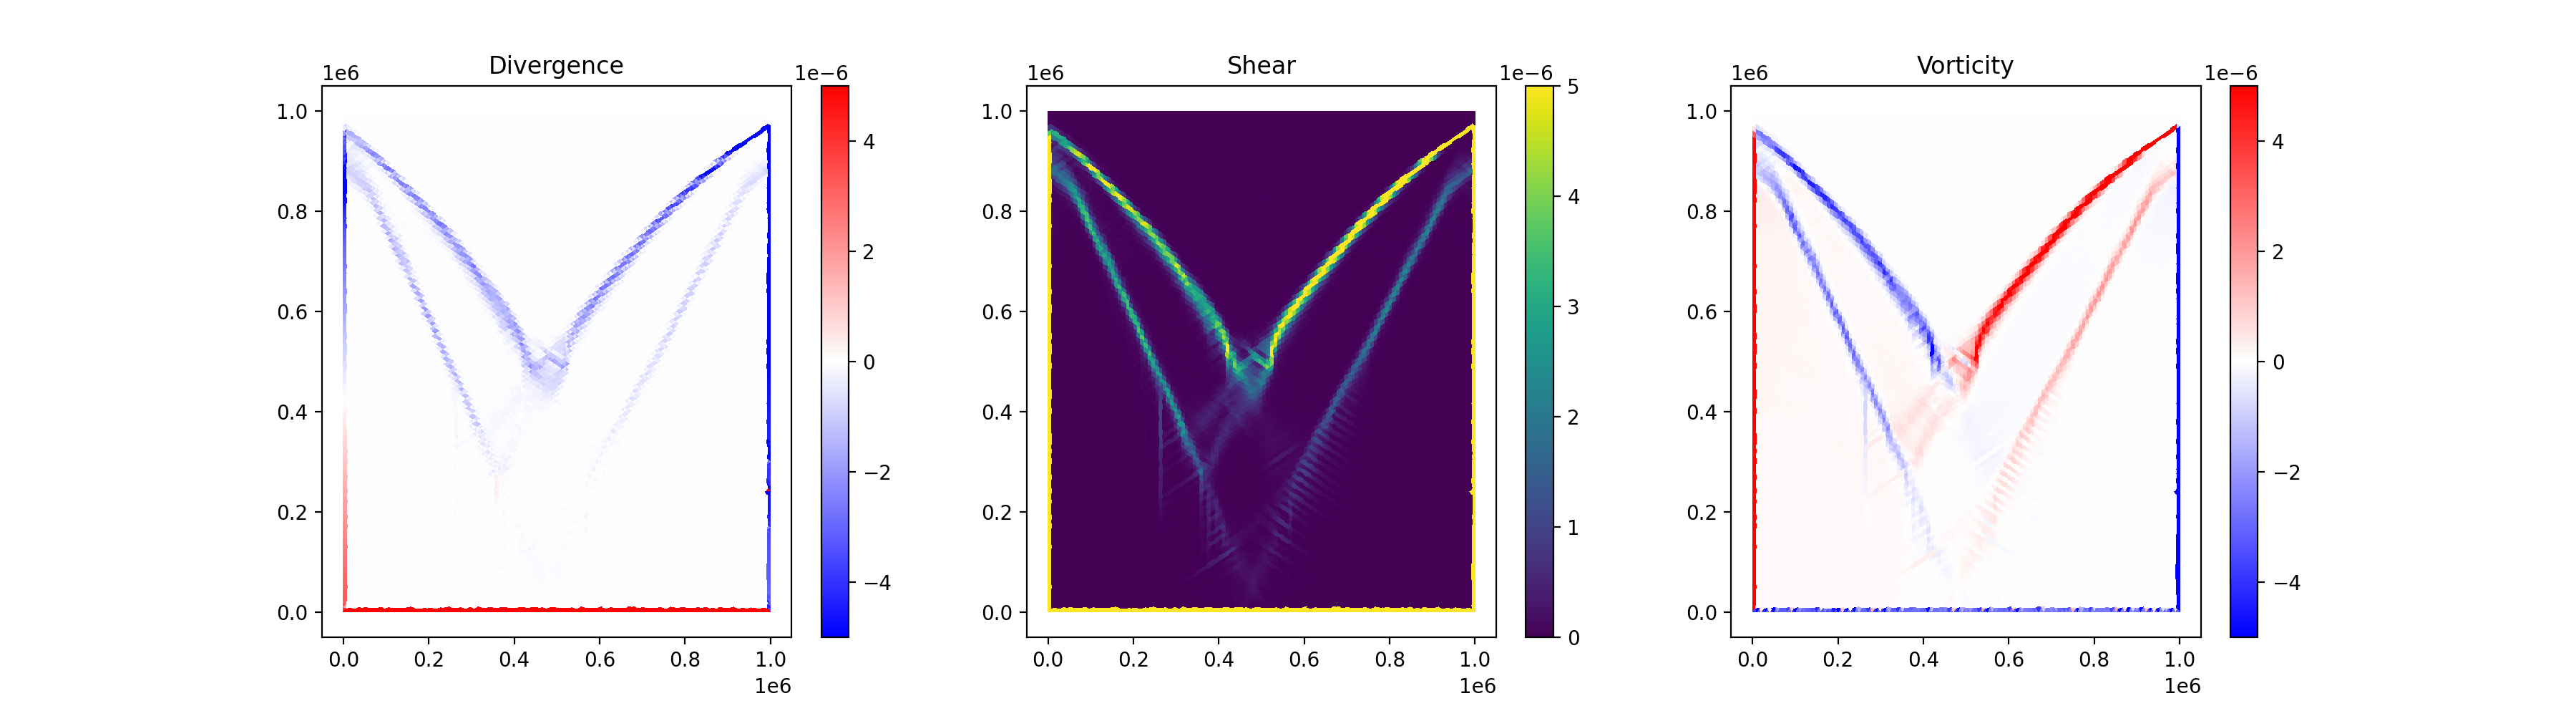

In [8]:
e1, e2, e3, a, p, t, x, y, u, v = get_deformation_2files(field_files[1000], field_files[1500])

max_div = 5e-6
fig, axs = plt.subplots(1,3, figsize=(18,5))
trpc0 = axs[0].tripcolor(x, y, e1, triangles=t, vmin=-max_div, vmax=max_div, cmap='bwr')
plt.colorbar(trpc0, ax=axs[0])
axs[0].set_title('Divergence')

trpc1 = axs[1].tripcolor(x, y, e2, triangles=t, vmin=0, vmax=max_div)
plt.colorbar(trpc1, ax=axs[1])
axs[1].set_title('Shear')

trpc2= axs[2].tripcolor(x, y, e3, triangles=t, vmin=-max_div, vmax=max_div, cmap='bwr')
plt.colorbar(trpc2, ax=axs[2])
axs[2].set_title('Vorticity')

plt.show()